# Visualizing the Counterfactual Augmentation (CFA) method on a 2D Toy Dataset

In this notebook, we will try to re-implement and visualize each step of the counterfactual augmentation algorithm in [1].

---

[1] M. Temraz, M. Keane, “Solving the Imbalance Class Problem Using a Counterfactual Method for Data Augmentation”, arXiv: 2111:03516 (preprint)

## 0. Generate 2d toy dataset

In [1]:
import pandas as pd
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, weights=[0.15, 0.85], random_state=727910251
)

X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
y = pd.Series(y, name="label")

Visualize our exemplary toy dataset:

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib as mpl

# Set the font to Computer Modern and font size to 10
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.serif'] = ['times']
#mpl.rcParams['font.size'] = 10
#mpl.rcParams['text.usetex'] = True

FIGSIZE = (5, 5)

In [191]:
def prepare_fig(ax):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

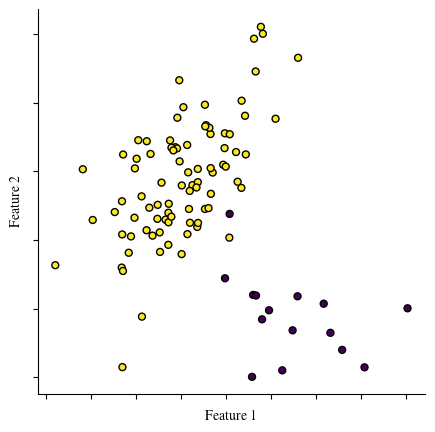

In [192]:
plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k")
prepare_fig(plt.gca())
plt.savefig('fig_dataset_before.pdf')

In [193]:
y.value_counts()

1    85
0    15
Name: label, dtype: int64

## 1. Divide Training Data into majority and minority subsets:

In [194]:
minority_label = 0
majority_label = 1

In [195]:
X_min = X[y == minority_label].copy()
X_maj = X[y == majority_label].copy()

In [196]:
X_min.shape[0]

15

In [197]:
X_maj.shape[0]

85

## 2. Compute CF-Set
Find 1-NN in p for each x (corresponding nearest minority sample for every majority sample):

In [198]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [199]:
nbrs = NearestNeighbors(n_neighbors=1).fit(X_min)

In [200]:
distances, indices = nbrs.kneighbors(X_maj)

In [201]:
nearest_neighbor_for_each_X_maj = X_min.iloc[indices[:, 0]].set_index(X_maj.index)
nearest_neighbor_for_each_X_maj

,feature_0,feature_1
0,0.074855,0.379293
1,0.074855,0.379293
2,0.074855,0.379293
3,0.074855,0.379293
4,0.074855,0.379293
...,...,...
94,0.074855,0.379293
95,0.074855,0.379293
96,0.074855,0.379293
98,0.074855,0.379293


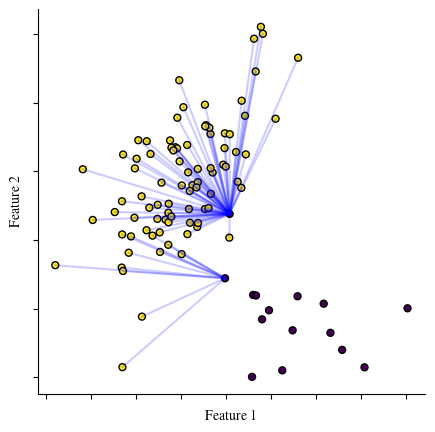

In [202]:
fig = plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k");
for i in range(len(X_maj)):
    x1, y1 = X_maj.iloc[i]
    x2, y2 = nearest_neighbor_for_each_X_maj.iloc[i]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.2)
#plt.title("Nearest minority neighbor for each majority instance")
prepare_fig(plt.gca())
plt.savefig('fig_CFA_step1.pdf')

## 3. Compute the tolerance limit, $t$

The paper describes finding match features as follows: 

> *CFA computes a tolerance by finding the mean and standard deviation for each feature. Then it allows features to match if their values are within +/- 10% of the standard deviation from the mean of all the values for that feature.*

Following this definition, it seems that match features are those that are close to the mean, and difference features are those that differ from the mean - **independent from the actual difference between a majority and minority sample in one CF-pair**.

In [203]:
stddev_percent = 10
upper_limit = X.mean() + stddev_percent/100 * X.std()
lower_limit = X.mean() - stddev_percent/100 * X.std()

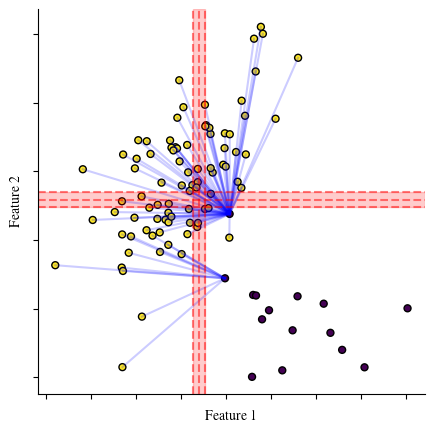

In [204]:
fig = plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k");
for i in range(len(X_maj)):
    x1, y1 = X_maj.iloc[i][:2]
    x2, y2 = nearest_neighbor_for_each_X_maj.iloc[i][:2]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.2)
    
plt.axvline(upper_limit[0], c="r", linestyle="--", alpha=0.5)
plt.axvline(X.mean()[0], c="r", linestyle="--", alpha=0.5)
plt.axvline(lower_limit[0], c="r", linestyle="--", alpha=0.5)
plt.axvspan(lower_limit[0], upper_limit[0], alpha=0.2, color='r')

plt.axhline(upper_limit[1], c="r", linestyle="--", alpha=0.5)
plt.axhline(X.mean()[1], c="r", linestyle="--", alpha=0.5)
plt.axhline(lower_limit[1], c="r", linestyle="--", alpha=0.5)
plt.axhspan(lower_limit[1], upper_limit[1], alpha=0.2, color='r')

#plt.title(f"Regions around mean")
prepare_fig(plt.gca())
plt.savefig('fig_CFA_weird_tol_definition.pdf')

We can see that using this definition - as we understood it - results in no "good" native counterfactuals with the 10%-threshold given by the authors and also seems counterintuitive (since it does not take into account the actual relationships between the majority instances and their nearest neigbors from the minority class, but instead only classifies "good" native counterfactuals as those that have similar values and are close to the mean, and not simply those that have similar values), and thus conclude that this cannot be what the authors meant.

For this reason, we assume that the authors meant this instead:

> *CFA computes a tolerance by finding the mean and standard deviation for each feature. Then it allows features to match if their values **differ from each other by less than** +/- 10% of the standard deviation <s>from the mean of all the values</s> for that feature.*

In [227]:
stddev_percent = 10
upper_limit = X_maj + stddev_percent/100 * X.std()
lower_limit = X_maj - stddev_percent/100 * X.std()

# check whether values are close to each other
nearest_neighbor_for_each_X_maj_within_tol = nearest_neighbor_for_each_X_maj[
    (nearest_neighbor_for_each_X_maj >= lower_limit) & (nearest_neighbor_for_each_X_maj <= upper_limit)
]
nearest_neighbor_for_each_X_maj_within_tol

,feature_0,feature_1
0,NaN,NaN
1,NaN,NaN
2,NaN,0.379293
3,NaN,NaN
4,NaN,NaN
...,...,...
94,NaN,NaN
95,0.074855,NaN
96,NaN,NaN
98,NaN,NaN


## 4. Compute number of feature-differences

In [228]:
num_difference_features = nearest_neighbor_for_each_X_maj_within_tol.isna().sum(axis=1)
num_difference_features

0     2
1     2
2     1
3     2
4     2
     ..
94    2
95    1
96    2
98    2
99    2
Length: 85, dtype: int64

## 5. Select all "good" native counterfactuals (with number of feature-differences $\le 1$)

> **NOTE:** We use a different number of feature-differences than the authors in this notebook (e.g. 1 instead of 2), since using the threshold of fd <= 2 would mean that **all** pairs are selected as good native counterfactuals because we are in 2D!

> Also: Counterfactuals with 0 difference-features are also removed, since they would only lead to the creation of majority instances in a later step (because they only have match-features).

In [229]:
((num_difference_features > 0) & (num_difference_features <= 1)).sum()

17

In [230]:
X_maj_unpaired = X_maj[(num_difference_features > 0) & (num_difference_features > 1)].copy()
X_maj_in_cf_set = X_maj[(num_difference_features > 0) & (num_difference_features <= 1)].copy()

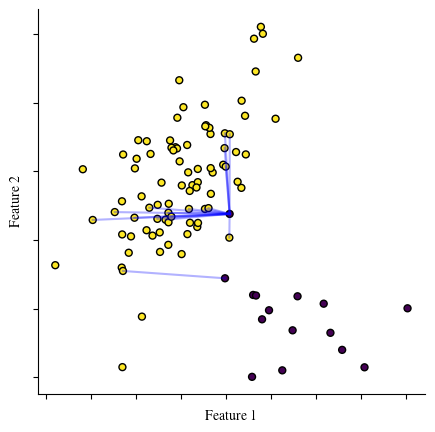

In [231]:
fig = plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k");
for i in range(len(X_maj_in_cf_set)):
    x1, y1 = X_maj_in_cf_set.iloc[i]
    x2, y2 = nearest_neighbor_for_each_X_maj.reindex(X_maj_in_cf_set.index).iloc[i]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.3)
#plt.title(f"'Good' native CF-pairs (fd = 1 with tol={stddev_percent}% of std)")
prepare_fig(plt.gca())
plt.savefig('fig_CFA_step2.pdf')

## 6. Find the nearest-neighbour for each unpaired instance 

In [210]:
nbrs = NearestNeighbors(n_neighbors=1).fit(X_maj_in_cf_set)
distances, indices = nbrs.kneighbors(X_maj_unpaired)
index_of_nearest_majority_neighbor_in_cf_set = X_maj_in_cf_set.iloc[indices[:, 0]].index
index_of_nearest_majority_neighbor_in_cf_set

Int64Index([82, 92,  2, 95, 72, 85, 72, 49, 41, 95,  2, 82, 85, 49,  2, 49, 72,
            92, 82, 95, 39, 95, 92, 95, 40, 49, 82, 92, 82, 71,  2, 92, 82, 92,
            39, 92, 95, 95, 85, 39, 82, 75, 82, 92, 49, 10, 41, 49, 40, 10, 46,
            39, 46, 82, 72, 95, 49, 37, 85, 95, 68, 82, 37, 72, 37, 49, 37,
            41],
           dtype='int64')

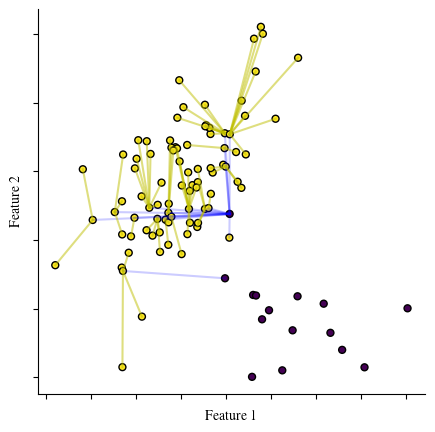

In [211]:
fig = plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k");
for i in range(len(X_maj_in_cf_set)):
    x1, y1 = X_maj_in_cf_set.iloc[i]
    x2, y2 = nearest_neighbor_for_each_X_maj.reindex(X_maj_in_cf_set.index).iloc[i]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.2)
for i in range(len(X_maj_unpaired)):
    x1, y1 = X_maj_unpaired.iloc[i]
    x2, y2 = X_maj_in_cf_set.iloc[indices[:, 0]].iloc[i]
    plt.plot([x1, x2], [y1, y2], 'y-', alpha=0.5)
#plt.title("Nearest neighbor in 'good' native CF-set for each unpaired instance")
prepare_fig(plt.gca())
plt.savefig('fig_CFA_step3.pdf')

## 7. Generate a synthetic counterfactual instance for each unpaired instance

In [152]:
# for match-features, set the value of the new synthetic counterfactual to the value of the unpaired instance
synthetic_counterfactuals = X_maj_unpaired.copy()
match_feature_mask = nearest_neighbor_for_each_X_maj_within_tol.reindex(index_of_nearest_majority_neighbor_in_cf_set).set_index(X_maj_unpaired.index).notna()
synthetic_counterfactuals = synthetic_counterfactuals[match_feature_mask] # set all difference-features to NaN
synthetic_counterfactuals

,feature_0,feature_1
0,NaN,0.798709
1,NaN,0.835344
3,NaN,1.034841
4,0.653635,NaN
5,-0.067217,NaN
...,...,...
93,-0.345978,NaN
94,NaN,0.527387
96,-0.465612,NaN
98,NaN,1.304940


In [153]:
# for difference-features, set the value of the new synthetic counterfactuals to the value of the nearest native counterfactual
synthetic_counterfactuals = synthetic_counterfactuals.fillna(
    nearest_neighbor_for_each_X_maj.loc[X_maj_in_cf_set.iloc[indices[:, 0]].index].set_index(X_maj_unpaired.index)
)
synthetic_counterfactuals

,feature_0,feature_1
0,0.074855,0.798709
1,0.074855,0.835344
3,0.074855,1.034841
4,0.653635,0.379293
5,-0.067217,0.379293
...,...,...
93,-0.345978,0.379293
94,0.074855,0.527387
96,-0.465612,0.379293
98,0.074855,1.304940


We can now add these synthetic counterfactuals to the dataset to augment it:

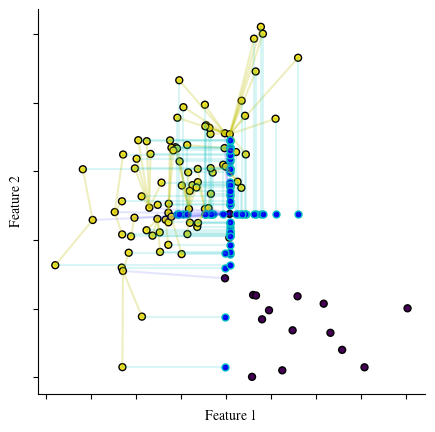

In [161]:
# red   = line connecting native cf-pair
# blue  = line connecting each unpaired instance to the next majority instance in a native cf-pair
# green = line from unpaired instance to new synthetic counterfactual


fig = plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k");
plt.scatter(synthetic_counterfactuals.values[:, 0], synthetic_counterfactuals.values[:, 1], marker="o", c="b", s=25, edgecolor="c");
for i in range(len(X_maj_in_cf_set)):
    x1, y1 = X_maj_in_cf_set.iloc[i]
    x2, y2 = nearest_neighbor_for_each_X_maj.reindex(X_maj_in_cf_set.index).iloc[i]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.1)
for i in range(len(X_maj_unpaired)):
    x1, y1 = X_maj_unpaired.iloc[i]
    x2, y2 = X_maj_in_cf_set.iloc[indices[:, 0]].iloc[i]
    plt.plot([x1, x2], [y1, y2], 'y-', alpha=0.25)
for i in range(len(X_maj_unpaired)):
    x1, y1 = X_maj_unpaired.iloc[i]
    x2, y2 = synthetic_counterfactuals.iloc[i]
    plt.plot([x1, x2], [y1, y2], 'c-', alpha=0.15)
#plt.title("Proposed synthetic counterfactuals (in cyan blue)")
prepare_fig(plt.gca())
plt.savefig('fig_CFA_step4.pdf')

We can see that some of the new synthetic minority instances seem to be closer to the majority instances rather than the minority instances.

In an earlier section of the paper, the authors mention that _"the class of this new [synthetic counterfactual] instance needs to be verified by the underlying ML model."_ 

We will do this in the next step. In this case, we use a random forest classifier, one of the models used by the authors (you could use any classifier here).

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 4, 6, 10, 20, 30, 50, 80, 100],
}

baseline_search = GridSearchCV(RandomForestClassifier(random_state=19231823), rf_param_grid, scoring="roc_auc")
baseline_search.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=19231823),
             param_grid={'max_depth': [None, 4, 6, 10, 20, 30, 50, 80, 100],
                         'n_estimators': [50, 100, 200, 400, 600]},
             scoring='roc_auc')

In [114]:
synthetic_counterfactual_predicted_class = baseline_search.predict(synthetic_counterfactuals) 

Now, we keep only those synthetic counterfactuals which are actually predicted to be in the minority class:

In [162]:
print(f"Dropping {(synthetic_counterfactual_predicted_class != minority_label).sum()} synthetic counterfactuals because they were predicted to be in the majority class")
synthetic_counterfactuals = synthetic_counterfactuals[(synthetic_counterfactual_predicted_class == minority_label)]
print(f"{len(synthetic_counterfactuals)} synthetic counterfactuals are added to the minority data")

Dropping 60 synthetic counterfactuals because they were predicted to be in the majority class
8 synthetic counterfactuals are added to the minority data


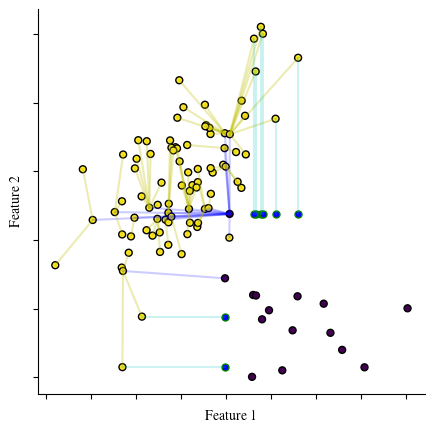

In [166]:
# red   = line connecting native cf-pair
# blue  = line connecting each unpaired instance to the next majority instance in a native cf-pair
# green = line from unpaired instance to new synthetic counterfactual


fig = plt.figure(figsize=FIGSIZE)
plt.scatter(X.values[:, 0], X.values[:, 1], marker="o", c=y.values, s=25, edgecolor="k");
plt.scatter(synthetic_counterfactuals.values[:, 0], synthetic_counterfactuals.values[:, 1], marker="o", c="b", s=25, edgecolor="g");
for i in range(len(X_maj_in_cf_set)):
    x1, y1 = X_maj_in_cf_set.iloc[i]
    x2, y2 = nearest_neighbor_for_each_X_maj.reindex(X_maj_in_cf_set.index).iloc[i]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.2)
for i in range(len(X_maj_unpaired)):
    x1, y1 = X_maj_unpaired.iloc[i]
    x2, y2 = X_maj_in_cf_set.iloc[indices[:, 0]].iloc[i]
    plt.plot([x1, x2], [y1, y2], 'y-', alpha=0.3)
for idx in synthetic_counterfactuals.index:
    x1, y1 = X_maj_unpaired.loc[idx]
    x2, y2 = synthetic_counterfactuals.loc[idx]
    plt.plot([x1, x2], [y1, y2], 'c-', alpha=0.2)
#plt.title("Accepted synthetic counterfactuals (in cyan blue)")
prepare_fig(plt.gca())
plt.savefig('fig_CFA_step5.pdf')

The new dataset is slightly more balanced:

In [167]:
X_cfa = X.copy()
y_cfa = y.copy()

X_cfa = pd.concat([X_cfa, synthetic_counterfactuals])
y_cfa = pd.concat([y_cfa, pd.Series([minority_label] * len(synthetic_counterfactuals), index=synthetic_counterfactuals.index)])

y_cfa.value_counts()

1    85
0    23
dtype: int64

However, the dataset is not yet fully balanced.

The paper also states: _"For our experiments, we oversample the minority class using each of the data augmentation methods until we have the same number of instances in each class. As a result, fully balanced datasets were created."_

So, apparently we need to run CFA multiple times, which we do below:

In [1]:
import sys 
import os
sys.path.insert(0, os.path.join("..", "src"))
from cfa import Iterative_CFA

In [169]:
X_final, y_final = Iterative_CFA(X_cfa, y_cfa, good_native_fd=1, baseline_model=baseline_search, visualize_with_pca=False)

Data distribution before CFA:
	Majority (1): 85, Minority (label 0): 23
Number of 'good' native counterfactuals in data: 25
Classifier predicted all new synthetic counterfactuals to be in the majority class! => No new minority instances => Terminating...
Data distribution after CFA:
	Majority (1): 85, Minority (label 0): 23


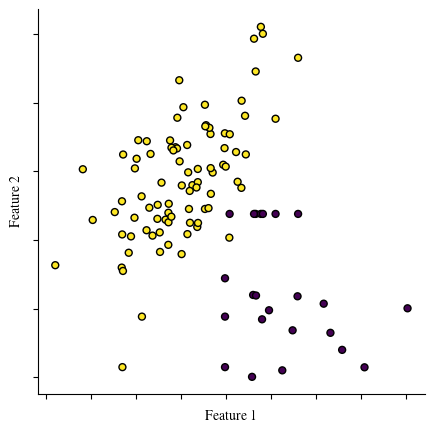

In [170]:
plt.figure(figsize=FIGSIZE)
plt.scatter(X_final.values[:, 0], X_final.values[:, 1], marker="o", c=y_final.values, s=25, edgecolor="k")
prepare_fig(plt.gca())
plt.savefig('fig_dataset_after.pdf')

In this case, the algorithm terminated early because all new synthetic counterfactuals were predicted to be in the majority class. Thus, it seems that it is not always possible to arrive at a fully balanced dataset following the steps outlined by the authors.